<font size="6">Accident Severity Prediction in UK.</font>



# Business purposes and metrics choosing

* Business purpose: 

To predict severity of accident: Serious or Slight. With a fact that accidence itself was occured already we would like to predict if it was serious or not. It can help to imergency services to give priority to several parallel accidents, make decision if ambulance is need, etc.
To stress: we dont predict accident itself, but its severity.

* Metrics choosing:


Confusion matrics with Actual and Predicted values
                        
True Negative  (TN)  Slight (Act)       Slight (Pred)   
False Positive (FP)  Slight (Act)       Serious(Pred)  
False Negative (FN)  Serious(Act)       Slihgt (Pred)  
True Positive  (TP)  Serious(Act)       Serious(Pred)
                        
* Our True is Serious Accident                    
* Choosed Metrics are : Precision, Recall and F1
                       

Reason : More intuitive Accuracy metric cannot be used since data is unbalanced (15:85). Serious is 15%  
High precision means we dont send ambulance where is not needed.  
High recall means we dont miss serious accident.  
F1 will get us ballnce between precision and recall. 

#  Import all libraries and dependencies

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from itertools import chain, combinations
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import f_classif
from functools import partial
from sklearn.feature_selection import VarianceThreshold
from numpy import set_printoptions
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
import scipy.stats as ss

# Services 
Includes global functions, tools,combiners, etc

## Helper Functions 

In [0]:
def map_severity(sev):
    mapping = {1:'Serious', 2:'Serious', 3:'Slight'}
    return mapping[sev]

In [0]:
def map_speed_to_kmh(miles):
    mapping = {10: 15 , 15: 25 ,20: 30, 30:50 , 40:65 , 50:80 , 60:100 , 70: 110}
    return mapping[miles]

In [0]:
def map_point_of_impact(point):
    mapping = {1:'Front'}
    if (point in mapping ):
        return mapping[point]
       
    return 'Other'

In [0]:
def map_vehicleType(type):
    mapping = {1:'Bike', 2:'Bike', 3:'Bike', 4:'Bike', 5:'Bike', 22:'Bike', 23:'Bike', 97:'Bike'}
    if (type in mapping ):
        return mapping[type]
       
    return 'Other'

In [0]:
def map_day_of_week(day):
    mapping = {1: 'Sunday', 2:'Monday', 3:'Tuesday', 4:'Wednesday', 5:'Thursday', 6:'Friday',7:'Saturday'}
    return mapping[day]


In [0]:
def map_overturned(action):
    mapping = {2: True, 3:True, 4:True, 5:True}
    if (action in mapping ):
        return mapping[action]
    return False

In [0]:
def map_weather(type):
    mapping = {1:'Fine', 2:'Rain', 3:'Snow', 4:'FineWing', 5:'RainWing', 6:'SnowWing', 7:'Fog',
            8: 'Other',9: 'Other', -1: 'Other'}   
    return mapping[type]

In [0]:
def map_urban(type):
    mapping = {1: True, 2:False, 3:False}
    
    return mapping[type]

In [0]:
def map_darkness(type):
    mapping = {1: False}
    if (type in mapping ):
        return mapping[type]
    
    return True

In [0]:
def map_gender(type):
    mapping = {1: False, 2:True, -1:False}
        
    return mapping[type]

In [0]:
def combineTwoVariables(i,s2):       
    s1 = str(i)
    s3 = s1 + " " +s2
    return s3

In [0]:
def percentage_serious_accidents(group):
    serious_count = group[group.Severity=='Serious'].count()
    total_count = group.shape[0]
    
    result = int((serious_count/total_count) * 100)   
    return result   

In [0]:
def dictionaryFeatureValueToPercentageSeriuosSeverity(dataFrame, feature):

    data = dataFrame.groupby([feature])[['Severity']].apply(percentage_serious_accidents).reset_index()
    data = data.set_index([feature])
    return data.T.to_dict('list')    

## Pipeline

Based on EDA cleans data from NaNs,mistakes,etc
Can be used for train, test, validtaion sets of data

In [0]:
def features_to_model(X):  
    
    return X[['Severity',
           'IsPedestrian','IsBike','IsFemale',
           'Number_of_Vehicles', 'Number_of_Casualties',
           'Speed_Risk', 'Road_Line_Risk',
           'Double_Front_Collision','IsOverturned',
           'Is_Urban', 'Is_Darkness']]
    

In [0]:
class DataPreprocessingPipeline:
    def __init__(self):
        self.accidents = {}
        
    def clean_data(self): 
        # Longitude & Latitude
        self.accidents.dropna(subset=['Longitude', 'Latitude'],inplace=True)       
       
        
    def convert_features(self):
    
        # Severity
        self.accidents['Severity'] = self.accidents['Accident_Severity'].apply(map_severity)
     
        # Pedestrians
        pedestrianData = uk_casualties[uk_casualties.Casualty_Class == 3]
        self.accidents = self.accidents.assign(IsPedestrian=self.accidents['Accident_Index'].isin(pedestrianData['Accident_Index']).astype(int))
     
        # Gender
        uk_casualties['Is_Female'] = uk_casualties.Sex_of_Casualty.apply(map_gender)
        femaleData = uk_casualties[uk_casualties.Is_Female == True]
        self.accidents = self.accidents.assign(IsFemale=self.accidents['Accident_Index'].isin(femaleData['Accident_Index']).astype(int))
        
        # Bikes
        uk_vehicles['IsBike'] =uk_vehicles['Vehicle_Type'].apply(map_vehicleType)
        bikesData = uk_vehicles[uk_vehicles.IsBike == 'Bike']
        self.accidents = self.accidents.assign(IsBike=self.accidents['Accident_Index'].isin(bikesData['Accident_Index']).astype(int))
    
        # Road Number        
        self.accidents['Road_Number'] = self.accidents['1st_Road_Number']
        self.accidents['Road_Number'] = self.accidents['Road_Number'].replace(10000, 0)

        self.accidents['LSOA'] = self.accidents['LSOA_of_Accident_Location']
        self.accidents['LSOA'].fillna('NoLSOA', inplace=True)        
       
        self.accidents['Road_Line'] = self.accidents.apply(lambda x: combineTwoVariables (x.Road_Number, x.LSOA),axis=1)
        dictRoadLineToPerc = dictionaryFeatureValueToPercentageSeriuosSeverity(self.accidents,'Road_Line')
        self.accidents['Road_Line_Risk'] = self.accidents['Road_Line'].map(dictRoadLineToPerc)
        self.accidents['Road_Line_Risk'] = self.accidents.Road_Line_Risk.apply(lambda x: x[0])  
    
        # Speed Limit        
        self.accidents['Speed_Limit_Kmh'] = self.accidents.Speed_limit.apply(map_speed_to_kmh)
        self.accidents['Speed_Risk'] = self.accidents.Speed_Limit_Kmh.apply(lambda x: x == 100)
        self.accidents['Speed_Risk']  = (self.accidents['Speed_Risk']  == True ).astype(int)
        
        # Point of impact
        uk_vehicles['Point_Of_Impact'] = uk_vehicles['1st_Point_of_Impact'].apply(map_point_of_impact)
        frontAccidenceData = uk_vehicles[uk_vehicles.Point_Of_Impact == 'Front']
        doubleFrontData = frontAccidenceData[frontAccidenceData.duplicated(['Accident_Index'])]
        self.accidents['Double_Front_Collision'] = self.accidents['Accident_Index'].isin(doubleFrontData['Accident_Index'])
         
        # Overturned
        uk_vehicles['Is_Overturned'] = uk_vehicles['Skidding_and_Overturning'].apply(map_overturned)
        overTurnData = uk_vehicles[uk_vehicles.Is_Overturned == True]
        self.accidents = self.accidents.assign(IsOverturned=self.accidents['Accident_Index'].isin(overTurnData['Accident_Index']).astype(int))
        
        # Urban or Rural area
        self.accidents['Is_Urban'] = self.accidents.Urban_or_Rural_Area.apply(map_urban)
        
        # Light conditions
        self.accidents['Is_Darkness'] = self.accidents.Light_Conditions.apply(map_darkness)
       
                
    def transform(self, X):
        
        self.accidents = X
        
        self.clean_data()
        self.convert_features()
       
        return features_to_model(self.accidents)
    
   

## Print Metrics

In [0]:
def print_metrics(y_tr,y_predict,true_def):
    print(confusion_matrix(y_true=y_tr,y_pred=y_predict,labels=true_def))
    tn, fp, fn, tp = confusion_matrix(y_true=y_tr,y_pred=y_predict,labels=true_def).ravel()
    print ('TN (Slight   Slight   )',tn)
    print ('FP (Slight   Serious  )',fp)
    print ('FN (Serious  Slight   )',fn)
    print ('TP (Serious  Serious  )',tp)
    print(classification_report(y_true=y_tr,y_pred=y_predict))
   

# The data

## Read data

In [0]:
pd.set_option('display.max_columns', None)
uk_accidents = pd.read_csv('UK_Accidents.csv')
uk_accidents.shape

(1640597, 32)

In [0]:
uk_accidents.head(2)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,3,17:42,12,E09000020,3,3218,6,30,0,-1,-1,0,0,1,1,2,2,0,0,1,1,E01002849
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,4,17:36,12,E09000020,4,450,3,30,6,2,5,0,0,5,4,1,1,0,0,1,1,E01002909


In [0]:
uk_casualties = pd.read_csv('UK_Casualties.csv')
uk_casualties.head(2)

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,3,1,37,7,2,1,1,0,0,-1,0,1
1,200501BS00002,1,1,2,1,37,7,3,0,0,0,4,-1,11,1


In [0]:
uk_casualties.shape

(2216720, 15)

In [0]:
uk_vehicles = pd.read_csv('UK_Vehicles.csv')
uk_vehicles.head(2)

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type
0,200501BS00001,1,9,0,18,0,0,0,0,0,0,1,1,15,2,74,10,-1,-1,-1,7,1
1,200501BS00002,1,11,0,4,0,3,0,0,0,0,4,1,1,1,42,7,8268,2,3,-1,-1


In [0]:
uk_vehicles.shape

(3004425, 22)

In [0]:
uk_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640597 entries, 0 to 1640596
Data columns (total 32 columns):
Accident_Index                                 1640597 non-null object
Location_Easting_OSGR                          1640486 non-null float64
Location_Northing_OSGR                         1640486 non-null float64
Longitude                                      1640486 non-null float64
Latitude                                       1640486 non-null float64
Police_Force                                   1640597 non-null int64
Accident_Severity                              1640597 non-null int64
Number_of_Vehicles                             1640597 non-null int64
Number_of_Casualties                           1640597 non-null int64
Date                                           1640597 non-null object
Day_of_Week                                    1640597 non-null int64
Time                                           1640464 non-null object
Local_Authority_(District)          

The data is real and taken from UK goverment site.  
The 'main' dataset is Accidents with 1600K rows 32 columns of accidents in UK between 2005 - 2015. Includes information about place, time, whether , light condition, etc.  
The 'helper' datasets are :   
Casualties (2200K rows, 16 columns): Inludes information about casualties: age, sex, if casual pedestrian or bus passanger...  
Vehicles (3000K, 25 columns): Includes information about vehicles involved in accidents: type, age, 1st point of impact, etc.  
Helper datasets connected to main dataset by Accident_Index key.

## Split data

In [0]:
train, test = train_test_split(uk_accidents, test_size=0.4,random_state = 54321)
test, valid = train_test_split(test, test_size=0.5)
print ("train shape:      ", train.shape)
print ("validation shape: ", valid.shape)
print ("test shape:       ", test.shape)

train shape:       (984358, 32)
validation shape:  (328120, 32)
test shape:        (328119, 32)


In [0]:
accidents = train

Conclusion : the data will be splitted to 3 sets:  
60% train  
20% valid  
20% test   

# Project strategy and goals

First, I will not try to cover all data with carefull analitics, but will try to create 1-3 strong win features from real life perspective. For example, the main factor that have influence to severity of accidents is speed collision. If I have had this information, project would be finished here.  
Second, the way is more important for me then final result in this study project. 

# EDA

## Accident severity
Target feature:  
1 - Fatal:   at least one person (driver or passenger) killed (within 30 days) by injures sustained in the crash.  
2 - Serious: at least one person injured and admitted to hospital but no fatalities.  
3 - Slight:  includes injuries not requiring medical treatment.

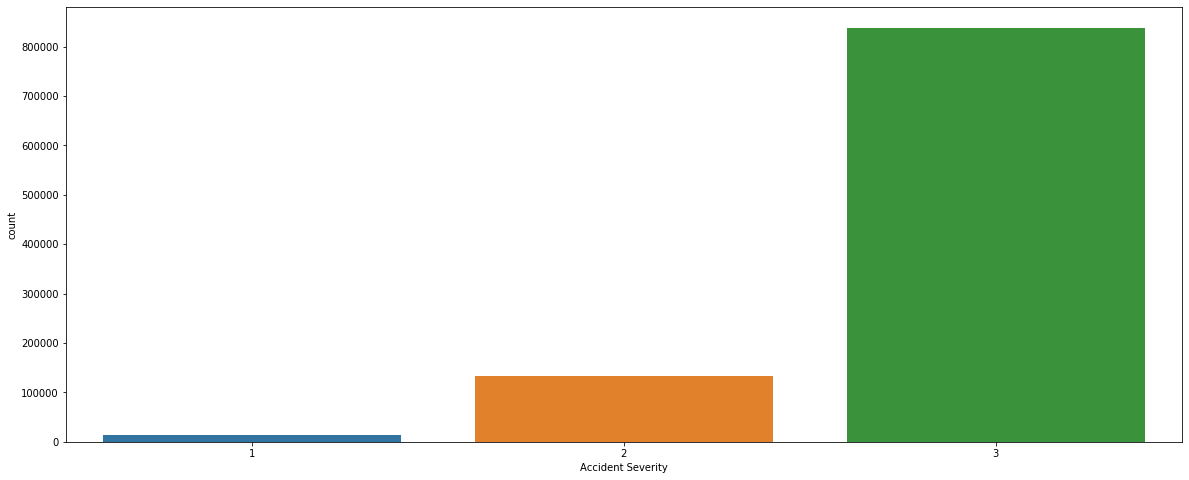

In [0]:
plt.figure(figsize=(20,8))
sns.countplot(x=accidents.Accident_Severity,data=accidents)
plt.xlabel("Accident Severity")
plt.show()

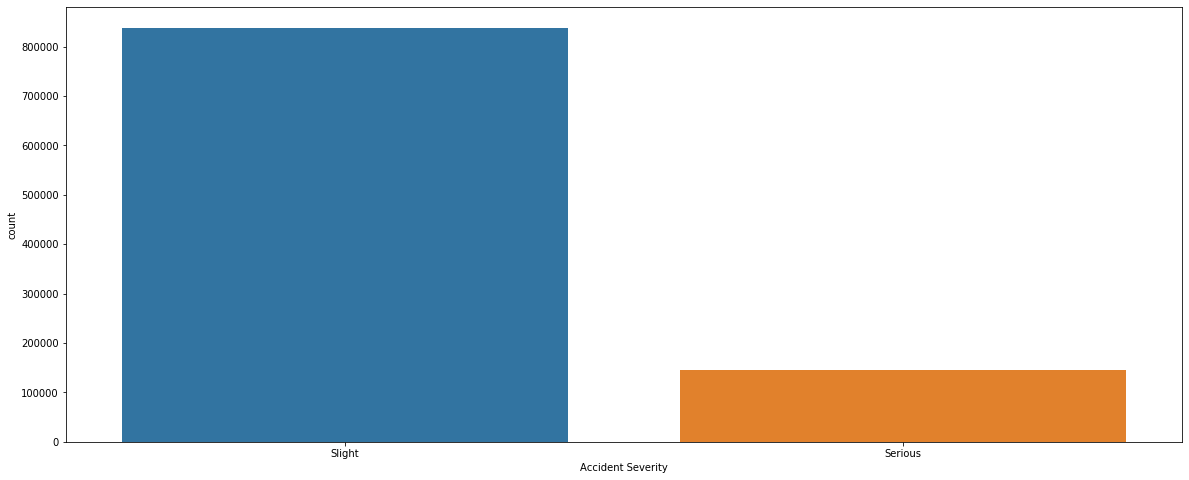

In [0]:
# combine Fatal and Serious accidents
accidents['Severity'] = accidents['Accident_Severity'].apply(map_severity)
plt.figure(figsize=(20,8))
sns.countplot(x=accidents.Severity,data=accidents)
plt.xlabel("Accident Severity")
plt.show()

In [0]:
seriousData = accidents[accidents.Severity == 'Serious']
slightData = accidents[accidents.Severity == 'Slight']
seriousCount = seriousData.shape[0]
slightCount = slightData.shape[0]
print ('Number of serious accidents   : ', seriousCount)
print ('Number of slight accidents    : ', slightCount)
print ('% seriuos from total accidents : ', seriousCount/accidents.shape[0])

Number of serious accidents   :  145910
Number of slight accidents    :  838448
% seriuos from total accidents :  0.14822859163028085


##### Conclusion: We combine Fatal and Serious severity. Our target will be binary : Serious(~15%) and Slight.

## Environment

### Longitude & Latitude

https://www.gps-coordinates.net/

In [0]:
# Road number 1 in UK. Cross almost all country includes London
road1 = accidents[accidents['1st_Road_Number']==1]
road1.shape

(12546, 33)

In [0]:
road1.head(2)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Severity
1404251,2013140004020,452129.0,409052.0,-1.214204,53.575477,14,3,2,2,20/02/2013,4,14:01,211,E08000017,2,1,3,70,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01007587,Slight
1584053,2014404DA0782,497052.0,236937.0,-0.586989,52.022331,40,3,2,1,27/08/2014,4,10:16,424,E06000056,1,1,3,70,0,-1,-1,0,0,0,1,1,1,0,0,2,1,E01017451,Slight


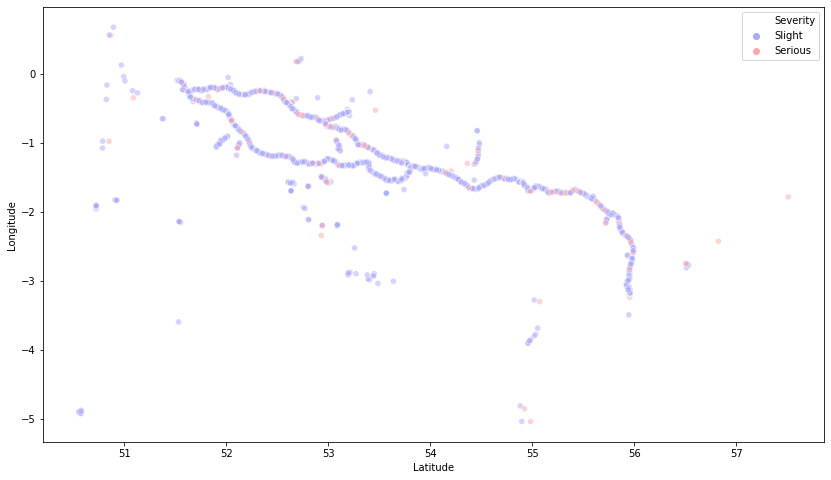

In [0]:
fig = plt.figure(figsize=(14,8))
sns.scatterplot(x=road1.Latitude, y=road1.Longitude, data=road1, hue='Severity', legend='full',palette='bwr', alpha=0.5)

In [0]:
accidents.dropna(subset=['Longitude', 'Latitude'],inplace=True)

Conclusion: Coordinates are not directly serve modeling , but can be used for analitics, collection additional data like address and creation new features. 111 NaN should be removed then.

### Weather

In [0]:
accidents['Weather'] = accidents['Weather_Conditions'].apply(map_weather)
accidents.Weather.value_counts()

Fine        785375
Rain        116732
Other        41632
RainWing     14075
FineWing     12659
Snow          7110
Fog           5430
SnowWing      1281
Name: Weather, dtype: int64

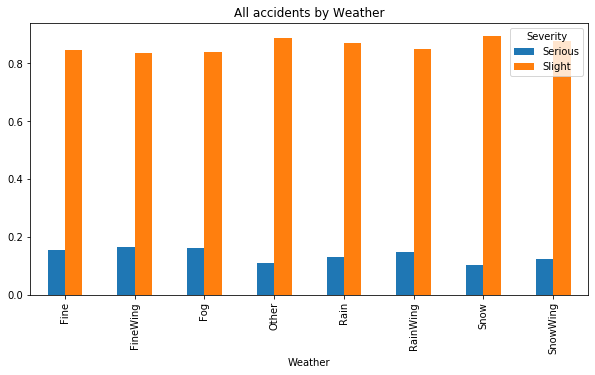

In [0]:
pd.crosstab(index=accidents['Weather'],values=accidents['Severity'], columns=accidents['Severity'],
aggfunc='count', normalize='index').plot.bar(title='All accidents by Weather',figsize=(10,5)).fontsize=10

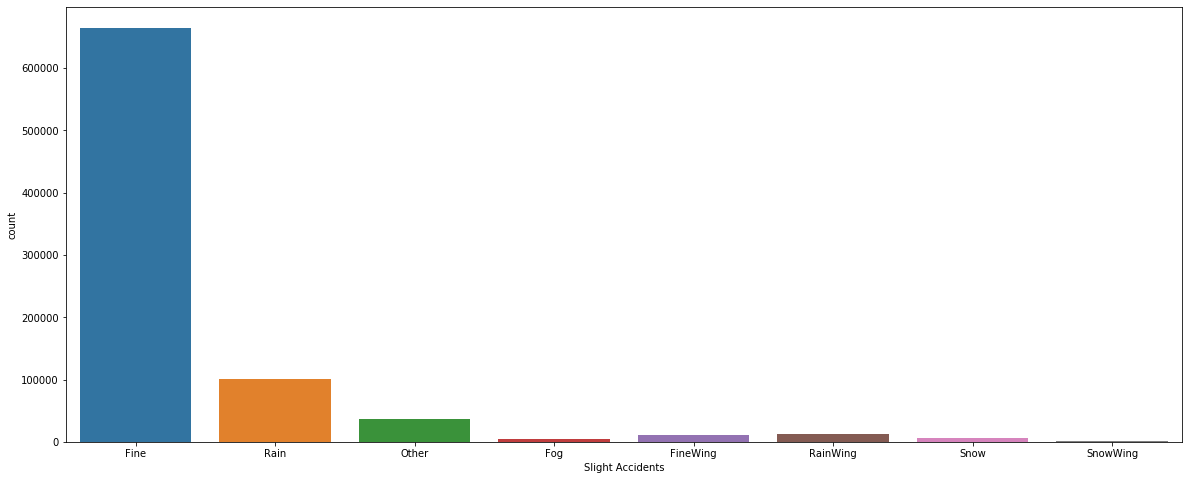

In [0]:
slightData = accidents[accidents.Severity == 'Slight']
plt.figure(figsize=(20,8))
sns.countplot(x=slightData.Weather ,data=slightData)
plt.xlabel("Slight Accidents")
plt.show()

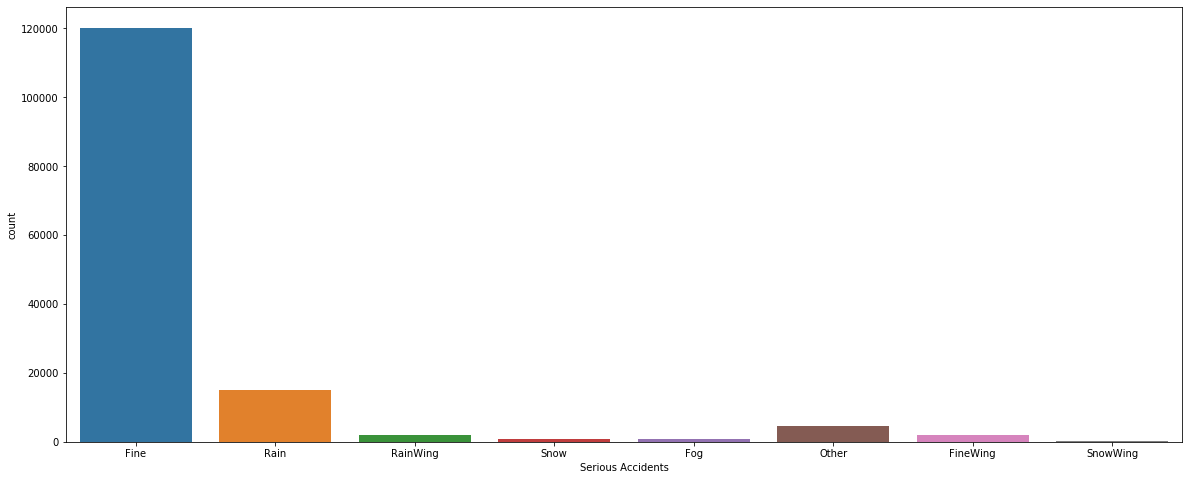

In [0]:
seriousData = accidents[accidents.Severity == 'Serious']
plt.figure(figsize=(20,8))
sns.countplot(x=seriousData.Weather ,data=seriousData)
plt.xlabel("Serious Accidents")
plt.show()

In [0]:
# key: weather type
# value: percentage of critical accidents
print (dictionaryFeatureValueToPercentageSeriuosSeverity(accidents,'Weather'))

{'Fine': [15], 'FineWing': [16], 'Fog': [16], 'Other': [11], 'Rain': [12], 'RainWing': [14], 'Snow': [10], 'SnowWing': [12]}


Conclusion: Weather has no impact to severity of accident. 

### Light conditions

In [0]:
# Relation Darkness (True) and DayLight
accidents['Is_Darkness'] = accidents.Light_Conditions.apply(map_darkness)
accidents.Is_Darkness.value_counts()

False    720973
True     263321
Name: Is_Darkness, dtype: int64

In [0]:
seriousData = accidents[accidents.Severity == 'Serious']
seriousData.Is_Darkness.value_counts()

False    99321
True     46580
Name: Is_Darkness, dtype: int64

In [0]:
seriousData.shape

(145901, 35)

In [0]:
numSerAcc = seriousData[seriousData.Is_Darkness == True].shape[0]
print ("% serious accidents while darkness: " , numSerAcc / seriousData.shape[0])

% serious accidents while darkness:  0.3192575787691654


Conclusion: 32% of serious accidents are happened while bad light conditions. Adding to model.

### Day of week

In [0]:
# convert day of week to categorical feature
accidents['Day_Of_Week'] = accidents.Day_of_Week.apply(map_day_of_week)

In [0]:
# percentege of critical accidents per day
print (dictionaryFeatureValueToPercentageSeriuosSeverity(accidents,'Day_Of_Week'))

{'Friday': [14], 'Monday': [13], 'Saturday': [16], 'Sunday': [17], 'Thursday': [14], 'Tuesday': [13], 'Wednesday': [13]}


Conclussion: Almost no effect to target. Saturday and Sunday a little more than average 15%

### Speed limit

In [0]:
# convert speed rom miles/h to Km/h
accidents['Speed_Limit_Kmh'] = accidents.Speed_limit.apply(map_speed_to_kmh)
accidents.Speed_Limit_Kmh.value_counts()

50     631567
100    157359
65      80877
110     72016
80      31785
30      10671
25         11
15          8
Name: Speed_Limit_Kmh, dtype: int64

In [0]:
# key: speed limit of the road
# value: percentage of critical accidents
print (dictionaryFeatureValueToPercentageSeriuosSeverity(accidents,'Speed_Limit_Kmh'))

{15: [37], 25: [9], 30: [15], 50: [13], 65: [14], 80: [17], 100: [21], 110: [14]}


In [0]:
# create a new column Speed_Risk on accidents dataframe
accidents['Speed_Risk'] = accidents.Speed_Limit_Kmh.apply(lambda x: x == 100)
accidents['Speed_Risk']  = (accidents['Speed_Risk']  == True ).astype(int)

Conclusion: Create a new continios categorical feature Speed_Risk. Speed 100 gives 21% of serious accidents (15% average)

### Urban or rural area

In [0]:
# Relation between urban (True) and rural areas
accidents['Is_Urban'] = accidents.Urban_or_Rural_Area.apply(map_urban)
accidents.Is_Urban.value_counts()

True     633176
False    351118
Name: Is_Urban, dtype: int64

In [0]:
urbanData = accidents[accidents.Is_Urban == True]
numSerAcc = urbanData[urbanData.Severity == 'Serious'].shape[0]
print ("% serious accidents in urban area: " , numSerAcc / urbanData.shape[0])

% serious accidents in urban area:  0.12936213627806487


In [0]:
ruralData = accidents[accidents.Is_Urban == False]
numSerAcc = ruralData[ruralData.Severity == 'Serious'].shape[0]
print ("% serious accidents in rural area: " , numSerAcc / ruralData.shape[0])

% serious accidents in rural area:  0.18225212036979022


Conclusion : In rural area percantage os Serious accidents is 18 against 13 in rural area. We add Is_Rural feature to model.

### Road number
An idea is to calculate percentage of critical accidents for each road in the country.To find dead roads.

In [0]:
# Road Number        
accidents['Road_Number'] = accidents['1st_Road_Number']
accidents.Road_Number.value_counts()

0       265510
1        12544
6        10829
4         9288
25        6437
         ...  
8248         1
1595         1
4243         1
1425         1
9051         1
Name: Road_Number, Length: 6436, dtype: int64

UK has 6435 roads with numbers, road 0 means accident happened in open field (road with official number).  
Another idea is to separate roads to lines, to have more granularity.

In [0]:
# road1 cross 110 administrative areas, so we can have 110 road lines with their own statistics
road1['District'] = road1['Local_Authority_(District)']
road1.District.value_counts()

3      967
434    612
30     553
321    456
146    451
      ... 
565      1
150      1
127      1
631      1
130      1
Name: District, Length: 110, dtype: int64

Continue.. Can separate more by LSOA.  A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA. Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.


In [0]:
accidents['LSOA'] = accidents['LSOA_of_Accident_Location']
road1['LSOA'] = road1['LSOA_of_Accident_Location']
# road 1 can be separated to 659 lines
road1.LSOA.value_counts()

E01023722    357
E01002795    180
E01017620    176
E01023725    152
E01023430    134
            ... 
E01026361      1
E01008384      1
E01000210      1
E01018553      1
E01015464      1
Name: LSOA, Length: 659, dtype: int64

In [0]:
# dont drop unknown but replace with demy info
accidents['Road_Number'].replace({0:10000},inplace = True)
accidents['LSOA'].fillna('A09999999', inplace=True)

In [0]:
accidents['Road_Line'] = accidents.apply(lambda x: combineTwoVariables (x.Road_Number, x.LSOA),axis=1)
dictRoadLineToPerc = dictionaryFeatureValueToPercentageSeriuosSeverity(accidents,'Road_Line')
accidents['Road_Line_Risk'] = accidents['Road_Line'].map(dictRoadLineToPerc)
accidents['Road_Line_Risk'] = accidents.Road_Line_Risk.apply(lambda x: x[0])  

Conclusion: Create a new continuous feture Road Line Risk with percantage of serious accidents. Continue to separate road in urban areas to streets or post indexes. This info can be generated from coordinates.

## Human

### Number of casualties

Text(0.5, 0, 'Number of casualties in serious accident')

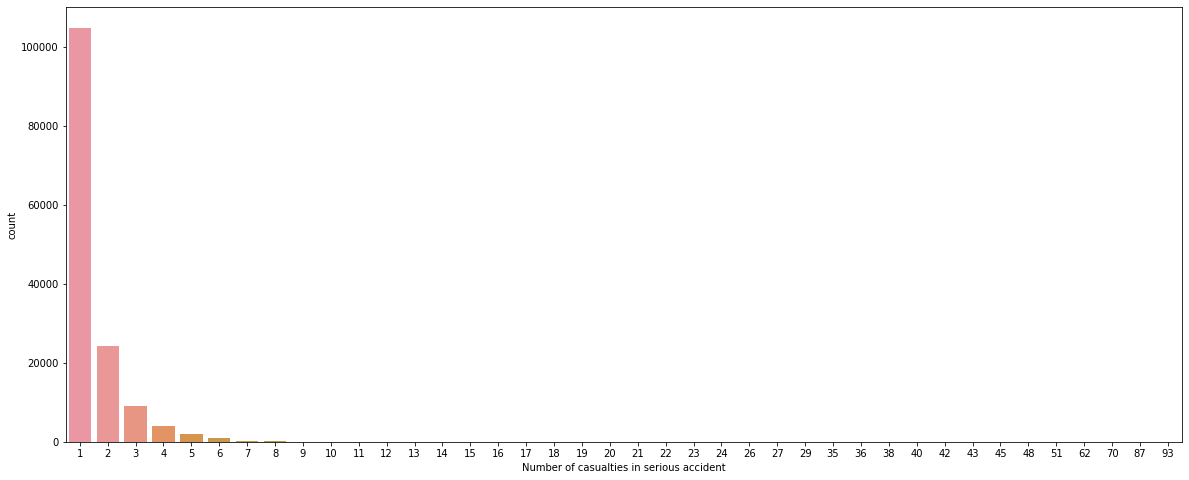

In [0]:
plt.figure(figsize=(20,8))
sns.countplot(x=seriousData.Number_of_Casualties ,data=seriousData)
plt.xlabel("Number of casualties in serious accident")

In [0]:
# key: number of casualties
# value: percentage of critical accidents
print (dictionaryFeatureValueToPercentageSeriuosSeverity(accidents,'Number_of_Casualties'))

{1: [13], 2: [15], 3: [20], 4: [25], 5: [31], 6: [36], 7: [37], 8: [40], 9: [38], 10: [36], 11: [45], 12: [26], 13: [61], 14: [59], 15: [58], 16: [53], 17: [77], 18: [66], 19: [44], 20: [33], 21: [71], 22: [37], 23: [50], 24: [100], 25: [0], 26: [50], 27: [100], 28: [0], 29: [80], 32: [0], 33: [0], 35: [100], 36: [100], 38: [100], 40: [100], 41: [0], 42: [100], 43: [50], 45: [100], 48: [100], 51: [100], 62: [100], 63: [0], 70: [100], 87: [100], 93: [100]}


Conclusion: with a rase of number of casualties , increased a chance to have serious injures. Will be taken to model as numerical feature.

### Pedestrians

Idea is that pedestrians that involved in accidents have chance much easier to be serious injured than drivers or passengers.

In [0]:
uk_casualties.head(2)

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,3,1,37,7,2,1,1,0,0,-1,0,1
1,200501BS00002,1,1,2,1,37,7,3,0,0,0,4,-1,11,1


In [0]:
# total number of casualties in dateset (~12% of total)
uk_casualties[uk_casualties.Casualty_Class == 3].shape[0]

275865

In [0]:
# create help dataframe pedestrian data
uk_casualties['Severity'] = uk_casualties['Casualty_Severity'].apply(map_severity)
pedestrianData = uk_casualties[uk_casualties.Casualty_Class == 3]
pedestrianData.Severity.value_counts()

Slight     213678
Serious     62187
Name: Severity, dtype: int64

In [0]:
# define a new column IsPedestrian on accidents dataframe
accidents = accidents.assign(IsPedestrian=accidents['Accident_Index'].isin(pedestrianData['Accident_Index']).astype(int))

Conclusion: Truth, in pedestrian group we have ~23% Serious injures( against 15% in total population). It will be added to to model as categorical feature.

### Gender
In terms of demographics, males are significantly less likely than females to suffer any level of injury

In [0]:
uk_casualties['Is_Female'] = uk_casualties.Sex_of_Casualty.apply(map_gender)

In [0]:
# Relations between Male and Female(True) in all accidents
uk_casualties.Is_Female.value_counts()

False    1292892
True      923828
Name: Is_Female, dtype: int64

In [0]:
# create help dataframe female data
femaleData = uk_casualties[uk_casualties.Is_Female == True]
femaleData.Severity.value_counts()

Slight     841106
Serious     82722
Name: Severity, dtype: int64

In [0]:
# define a new column IsFemale on accidents dataframe
accidents = accidents.assign(IsFemale=accidents['Accident_Index'].isin(femaleData['Accident_Index']).astype(int))

## Vehicles

### Number of vehicles

In [0]:
accidents.Number_of_Vehicles.value_counts()

2     584466
1     298690
3      78769
4      16723
5       3689
6       1131
7        420
8        210
9         87
10        43
11        17
12        11
13        10
14         8
16         5
15         3
18         3
20         2
34         1
19         1
21         1
22         1
28         1
32         1
67         1
Name: Number_of_Vehicles, dtype: int64

Text(0.5, 0, 'Number of vehicles in serious accident')

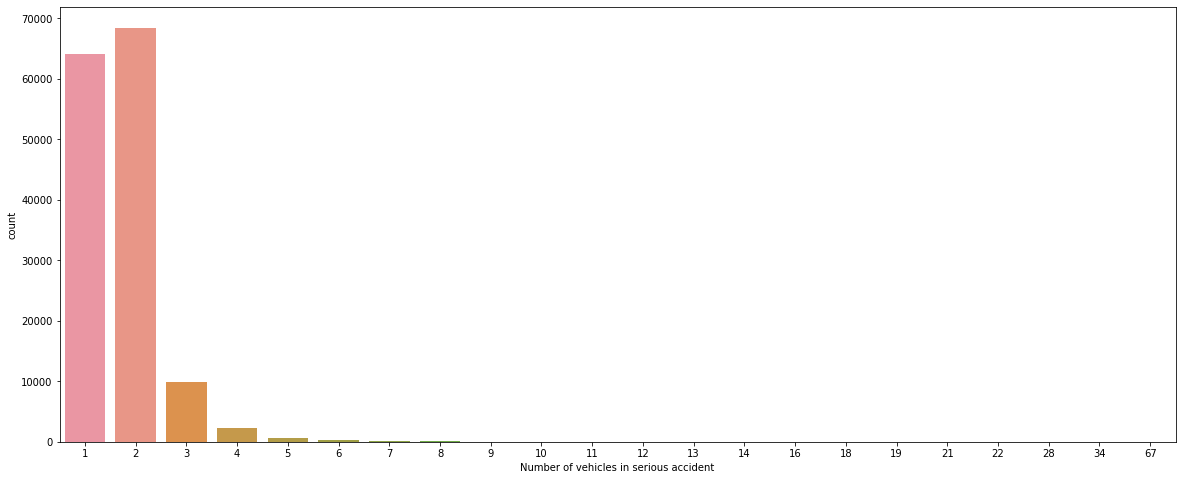

In [0]:
plt.figure(figsize=(20,8))
sns.countplot(x=seriousData.Number_of_Vehicles ,data=seriousData)
plt.xlabel("Number of vehicles in serious accident")

Conclussion: Data is clean. Will be taken to model as numerical feature.

### Bikes
Like pedestrians, bikers is a group risk.Bikes includes all kind of this type vehichle: bicycle, bike, etc

In [0]:
uk_vehicles.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type
0,200501BS00001,1,9,0,18,0,0,0,0,0,0,1,1,15,2,74,10,-1,-1,-1,7,1
1,200501BS00002,1,11,0,4,0,3,0,0,0,0,4,1,1,1,42,7,8268,2,3,-1,-1
2,200501BS00003,1,11,0,17,0,0,0,4,0,0,4,1,1,1,35,6,8300,2,5,2,1
3,200501BS00003,2,9,0,2,0,0,0,0,0,0,3,1,15,1,62,9,1762,1,6,1,1
4,200501BS00004,1,9,0,18,0,0,0,0,0,0,1,1,15,2,49,8,1769,1,4,2,1


In [0]:
uk_vehicles['IsBike'] = uk_vehicles['Vehicle_Type'].apply(map_vehicleType)
uk_vehicles.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,IsBike
0,200501BS00001,1,9,0,18,0,0,0,0,0,0,1,1,15,2,74,10,-1,-1,-1,7,1,Other
1,200501BS00002,1,11,0,4,0,3,0,0,0,0,4,1,1,1,42,7,8268,2,3,-1,-1,Other
2,200501BS00003,1,11,0,17,0,0,0,4,0,0,4,1,1,1,35,6,8300,2,5,2,1,Other
3,200501BS00003,2,9,0,2,0,0,0,0,0,0,3,1,15,1,62,9,1762,1,6,1,1,Other
4,200501BS00004,1,9,0,18,0,0,0,0,0,0,1,1,15,2,49,8,1769,1,4,2,1,Other


In [0]:
# total number of bikes
bikesData = uk_vehicles[uk_vehicles.IsBike == 'Bike']
bikesData.shape

(404813, 23)

In [0]:
# define a new column isBike on accidents dataframe
accidents = accidents.assign(IsBike=accidents['Accident_Index'].isin(bikesData['Accident_Index']).astype(int))
accidents.head(2)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Severity,Weather,Is_Darkness,Day_Of_Week,Speed_Limit_Kmh,Speed_Risk,Is_Urban,Road_Number,LSOA,Road_Line,Road_Line_Risk,IsPedestrian,IsFemale,IsBike
318845,200642I320408,599360.0,204790.0,0.883985,51.706366,42,3,1,1,14/08/2006,2,20:44,458,E10000012,4,1021,2,60,0,0,-1,0,0,0,6,1,1,0,0,2,1,E01021907,Slight,Fine,True,Monday,100,1,False,1021,E01021907,1021 E01021907,23,0,0,0
113767,2005350628305,518010.0,299270.0,-0.259858,52.578417,35,3,2,1,10/12/2005,7,13:30,394,E06000031,5,61,6,30,3,4,6,0,0,0,1,1,1,0,0,1,1,E01015692,Slight,Fine,False,Saturday,50,0,True,61,E01015692,61 E01015692,14,0,0,1


In [0]:
accidents[accidents.IsBike==1].Severity.value_counts()

Slight     182713
Serious     53456
Name: Severity, dtype: int64

Conclusion: ~23% of accidents with bikes are Serious. We create a new categorical feature IsBike

### Points of Impact
An idea is to figure out accident with two cars with front collision. The spped collision in this case is double. We expect that this accidenmust be serious.  

In [0]:
uk_vehicles.head(2)

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,IsBike
0,200501BS00001,1,9,0,18,0,0,0,0,0,0,1,1,15,2,74,10,-1,-1,-1,7,1,Other
1,200501BS00002,1,11,0,4,0,3,0,0,0,0,4,1,1,1,42,7,8268,2,3,-1,-1,Other


In [0]:
uk_vehicles['Point_Of_Impact'] = uk_vehicles['1st_Point_of_Impact'].apply(map_point_of_impact)

In [0]:
# half of car with Front point of impact.
# but we need to find minimum two cars from same accidents
uk_vehicles['Point_Of_Impact'].value_counts()

Other    1530451
Front    1473974
Name: Point_Of_Impact, dtype: int64

In [0]:
# define data with car with front collision
frontAccidenceData = uk_vehicles[uk_vehicles.Point_Of_Impact == 'Front']

In [0]:
# in this data get duplicates - it will cars with double front collision (243K cars)
doubleFrontData = frontAccidenceData[frontAccidenceData.duplicated(['Accident_Index'])] 
doubleFrontData.shape


(243308, 24)

In [0]:
# define a new column Double_Front_Collision on accident dataframe
accidents['Double_Front_Collision'] = accidents['Accident_Index'].isin(doubleFrontData['Accident_Index'])

In [0]:
accidents.Double_Front_Collision.value_counts()

False    849841
True     134453
Name: Double_Front_Collision, dtype: int64

In [0]:
doubleFrontAccident = accidents[accidents.Double_Front_Collision==True]
doubleFrontAccident.Severity.value_counts()

Slight     110112
Serious     24341
Name: Severity, dtype: int64

Conclusion: Just 18% of double front collision is serious. We will add new categorical feature.

### Overturned
If car is overturned after accident its for sure should be serious

In [0]:
uk_vehicles['Is_Overturned'] = uk_vehicles['Skidding_and_Overturning'].apply(map_overturned)

In [0]:
# Number of overturned cars
uk_vehicles['Is_Overturned'].value_counts()

False    2896894
True      107531
Name: Is_Overturned, dtype: int64

In [0]:
# add a new column IsOverturned to accidents dataframe
overTurnData = uk_vehicles[uk_vehicles.Is_Overturned == True]
accidents = accidents.assign(IsOverturned=accidents['Accident_Index'].isin(overTurnData['Accident_Index']).astype(int))
accidents.head(2)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Severity,Weather,Is_Darkness,Day_Of_Week,Speed_Limit_Kmh,Speed_Risk,Is_Urban,Road_Number,LSOA,Road_Line,Road_Line_Risk,IsPedestrian,IsFemale,IsBike,Double_Front_Collision,IsOverturned
318845,200642I320408,599360.0,204790.0,0.883985,51.706366,42,3,1,1,14/08/2006,2,20:44,458,E10000012,4,1021,2,60,0,0,-1,0,0,0,6,1,1,0,0,2,1,E01021907,Slight,Fine,True,Monday,100,1,False,1021,E01021907,1021 E01021907,23,0,0,0,False,0
113767,2005350628305,518010.0,299270.0,-0.259858,52.578417,35,3,2,1,10/12/2005,7,13:30,394,E06000031,5,61,6,30,3,4,6,0,0,0,1,1,1,0,0,1,1,E01015692,Slight,Fine,False,Saturday,50,0,True,61,E01015692,61 E01015692,14,0,0,1,False,0


In [0]:
accidents.IsOverturned.value_counts()

0    921091
1     63203
Name: IsOverturned, dtype: int64

In [0]:
overturned = accidents[accidents.IsOverturned==True]
overturned.Severity.value_counts()

Slight     49126
Serious    14077
Name: Severity, dtype: int64

Conclussion: Just 22 % of accidents with overturning cause to serious injures.

# Transform data

In [0]:
# data from EDA 
accidentsToModel = features_to_model(accidents)

# Init pipeline
pipeline = DataPreprocessingPipeline()
trainToModel = pipeline.transform(train)
print("Compare data from EDA and pipeline transfomation.Result is: ", trainToModel.equals(accidentsToModel))


Compare data from EDA and pipeline transfomation.Result is:  True


In [0]:
accidentsToModel.head()

,Severity,IsPedestrian,IsBike,IsFemale,Number_of_Vehicles,Number_of_Casualties,Speed_Risk,Road_Line_Risk,Double_Front_Collision,IsOverturned,Is_Urban,Is_Darkness
318845,Slight,0,0,0,1,1,1,23,False,0,False,True
113767,Slight,0,1,0,2,1,0,14,False,0,True,False
559328,Slight,0,0,1,1,1,1,27,False,1,False,True
547925,Slight,1,0,0,1,1,0,0,False,0,True,False
1278474,Slight,0,0,1,3,3,0,10,True,0,True,False


In [0]:
trainToModel.head()

,Severity,IsPedestrian,IsBike,IsFemale,Number_of_Vehicles,Number_of_Casualties,Speed_Risk,Road_Line_Risk,Double_Front_Collision,IsOverturned,Is_Urban,Is_Darkness
318845,Slight,0,0,0,1,1,1,23,False,0,False,True
113767,Slight,0,1,0,2,1,0,14,False,0,True,False
559328,Slight,0,0,1,1,1,1,27,False,1,False,True
547925,Slight,1,0,0,1,1,0,0,False,0,True,False
1278474,Slight,0,0,1,3,3,0,10,True,0,True,False


In [0]:
X_train = trainToModel.drop('Severity', axis=1)
y_train = trainToModel['Severity']

In [0]:
X_test = trainToModel.drop('Severity', axis=1)
y_train = trainToModel['Severity']

In [0]:
validToModel = pipeline.transform(valid)
X_valid = validToModel.drop('Severity', axis=1)
y_valid = validToModel['Severity']

In [0]:
testToModel = pipeline.transform(test)
X_test = testToModel.drop('Severity', axis=1)
y_test = testToModel['Severity']

# Balance data

In [0]:
"""data_true = trainToModel[trainToModel.Severity == 'Serious']
data_false = trainToModel[trainToModel.Severity == 'Slight'].sample(data_true.shape[0])
balanced_train = pd.concat([data_false,data_true])
X_train = balanced_train.drop('Severity', axis=1)
y_train = balanced_train['Severity']
"""


"data_true = trainToModel[trainToModel.Severity == 'Serious']\ndata_false = trainToModel[trainToModel.Severity == 'Slight'].sample(data_true.shape[0])\nbalanced_train = pd.concat([data_false,data_true])\nX_train = balanced_train.drop('Severity', axis=1)\ny_train = balanced_train['Severity']\n"

Conclusion: Trying oversampling data cause to same final resuls. I decided to fit model with unballanced data but to give weight to serious accidents

# Feature Importance

In [0]:
selector = SelectKBest(f_classif, k = 10)
X_new = selector.fit_transform(X_train, y_train)
names = X_train.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

             Feat_names       F_Scores
6        Road_Line_Risk  162392.978737
1                IsBike   15250.647410
0          IsPedestrian   10480.215802
5            Speed_Risk    7141.805991
3    Number_of_Vehicles    6625.573141
2              IsFemale    5569.751055
4  Number_of_Casualties    5325.133323
8              Is_Urban    5029.862419
7          IsOverturned    2977.832867
9           Is_Darkness    2345.200428


# Model  
Finally I used Decision Tree model. Random Forest or other more complicated models like KNN or XGBoost give same results

## Grid Search
Find best parameters for Decision Tree

In [0]:
"""parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf_tree=DecisionTreeClassifier()
clf=GridSearchCV(clf_tree,parameters)
best_model = clf.fit(X_train,y_train)
# View best hyperparameters
print('min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('max_depth:', best_model.best_estimator_.get_params()['max_depth'])
min_samples_split: 10
max_depth: 9
    """

"parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}\nclf_tree=DecisionTreeClassifier()\nclf=GridSearchCV(clf_tree,parameters)\nbest_model = clf.fit(X_train,y_train)\n# View best hyperparameters\nprint('min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])\nprint('max_depth:', best_model.best_estimator_.get_params()['max_depth'])\nmin_samples_split: 10\nmax_depth: 9\n    "

## Train

In [0]:
true_def = ["Slight","Serious"]
model = DecisionTreeClassifier(class_weight={"Serious": 2, "Slight": 1 },min_samples_split=10,max_depth=9) #2:1
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={'Serious': 2, 'Slight': 1},
                       criterion='gini', max_depth=9, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [0]:
y_predict = model.predict(X_train)
print_metrics(y_train,y_predict,true_def)

[[779903  58490]
 [ 86380  59521]]
TN (Slight   Slight   ) 779903
FP (Slight   Serious  ) 58490
FN (Serious  Slight   ) 86380
TP (Serious  Serious  ) 59521
              precision    recall  f1-score   support

     Serious       0.50      0.41      0.45    145901
      Slight       0.90      0.93      0.92    838393

    accuracy                           0.85    984294
   macro avg       0.70      0.67      0.68    984294
weighted avg       0.84      0.85      0.85    984294



## Validation

In [0]:
y_predict = model.predict(X_valid)
print_metrics(y_valid,y_predict,true_def)

[[259059  20583]
 [ 21099  27355]]
TN (Slight   Slight   ) 259059
FP (Slight   Serious  ) 20583
FN (Serious  Slight   ) 21099
TP (Serious  Serious  ) 27355
              precision    recall  f1-score   support

     Serious       0.57      0.56      0.57     48454
      Slight       0.92      0.93      0.93    279642

    accuracy                           0.87    328096
   macro avg       0.75      0.75      0.75    328096
weighted avg       0.87      0.87      0.87    328096



## Test

In [0]:
y_predict = model.predict(X_test)
print_metrics(y_test,y_predict,true_def)

[[258096  20949]
 [ 21218  27833]]
TN (Slight   Slight   ) 258096
FP (Slight   Serious  ) 20949
FN (Serious  Slight   ) 21218
TP (Serious  Serious  ) 27833
              precision    recall  f1-score   support

     Serious       0.57      0.57      0.57     49051
      Slight       0.92      0.92      0.92    279045

    accuracy                           0.87    328096
   macro avg       0.75      0.75      0.75    328096
weighted avg       0.87      0.87      0.87    328096



## Random Forest

In [0]:
modelRF = RandomForestClassifier(class_weight={'Serious': 2, 'Slight': 1}, n_estimators=100, min_samples_split=10,max_depth=9)


In [0]:
modelRF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'Serious': 2, 'Slight': 1},
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_predict = modelRF.predict(X_train)
print_metrics(y_train,y_predict,true_def)

[[793799  44594]
 [ 92971  52930]]
TN (Slight   Slight   ) 793799
FP (Slight   Serious  ) 44594
FN (Serious  Slight   ) 92971
TP (Serious  Serious  ) 52930
              precision    recall  f1-score   support

     Serious       0.54      0.36      0.43    145901
      Slight       0.90      0.95      0.92    838393

    accuracy                           0.86    984294
   macro avg       0.72      0.65      0.68    984294
weighted avg       0.84      0.86      0.85    984294



In [0]:
y_predict = modelRF.predict(X_test)
print_metrics(y_test,y_predict,true_def)

[[261785  17260]
 [ 22921  26130]]
TN (Slight   Slight   ) 261785
FP (Slight   Serious  ) 17260
FN (Serious  Slight   ) 22921
TP (Serious  Serious  ) 26130
              precision    recall  f1-score   support

     Serious       0.60      0.53      0.57     49051
      Slight       0.92      0.94      0.93    279045

    accuracy                           0.88    328096
   macro avg       0.76      0.74      0.75    328096
weighted avg       0.87      0.88      0.87    328096



Random Forest gives same result.

# Summary (for metrics and business) 

## Results & conclusions

* So far we have balanced 57% in three metrics: Precision, Recall and F1 by Decision Tree.
* From three different direction (Environment,Human,Vehicles) we found only one win feature: "Road Line Risk".  
  Without this feature we have follow results: Precision: 0.42  Recall: 0.19   F1:  0.26  
  Human or Vehicles fields have no potential for model improvment. 
* Continue: To improve "Road Line Risk" by separation to smaller areas. Believe, it will get another 10-15%.
  Two ways to achieve it:  
  1) Convert Lat Long to address (Reverse Geocoding) and separate road by streets or postal index. Problem here is do it for     large dataset for 1.6 millions rows. Quistion of time or/and money.  
  2) Build own network(s) by dividing all country to squires 1-5 km depend on the area (urban or rural). Requare some development and testing.
  

## Customization

We provide OOTB solution with balanced Precision (57%) and Recall(57%)  
Assume, customer has limited number of ambulanced and want to send it to really serious accident. But sometimes have to exit from garage.   
By changed class_weight on the model we can simple customise it: reduce recall to some minimum  and increase Precision.

In [0]:
modelCust = DecisionTreeClassifier(class_weight={"Serious": 5, "Slight": 9 },min_samples_split=10,max_depth=9) #2:1
modelCust.fit(X_test, y_test)
y_predict = modelCust.predict(X_test)
print_metrics(y_test,y_predict,true_def)

[[277562   1483]
 [ 38397  10654]]
TN (Slight   Slight   ) 277562
FP (Slight   Serious  ) 1483
FN (Serious  Slight   ) 38397
TP (Serious  Serious  ) 10654
              precision    recall  f1-score   support

     Serious       0.88      0.22      0.35     49051
      Slight       0.88      0.99      0.93    279045

    accuracy                           0.88    328096
   macro avg       0.88      0.61      0.64    328096
weighted avg       0.88      0.88      0.85    328096

